In [1]:
import pandas as pd
import glob
import os

# Define the path to the datasets directory
dataset_path = 'datasets'

# Get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(dataset_path, '*.csv'))

# Load all CSV files into a list of DataFrames
dfs = []
for filename in csv_files:
    df = pd.read_csv(filename)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
if dfs:
    full_df = pd.concat(dfs, ignore_index=True)
    
    # Remove the filename column if it exists
    if 'filename' in full_df.columns:
        full_df = full_df.drop(columns=['filename'])
    
    # Export the unified dataframe to a CSV file
    full_df.to_csv('unified_dataset.csv', index=False)
    print("Unified dataset exported to 'unified_dataset.csv'.")
    
    print("Dataset loaded successfully.")
    print(f"Total rows: {len(full_df)}")
    display(full_df.head())
else:
    print("No CSV files found in the datasets directory.")

Unified dataset exported to 'unified_dataset.csv'.
Dataset loaded successfully.
Total rows: 4200


,person,audio,noise,snr,provider,text,status,transcription_time
0,p7,1,cafe,0dB,custom,Genera una cotización para el cliente con fáci...,success,1.65
1,p7,1,cafe,5dB,custom,Genera una cotización para el cliente con PUC ...,success,1.56
2,p7,1,cafe,10dB,custom,Genera una cotización para el cliente con Puff...,success,1.59
3,p7,1,clean,NaN,custom,Genera una cotización para el cliente con FooF...,success,1.66
4,p7,1,traffic,0dB,custom,"genera una cotización para el cliente fácil, c...",success,1.53


In [2]:
mean_time_by_provider = full_df.groupby('provider')['transcription_time'].mean()
print("Mean Transcription Time by Provider:")
print(mean_time_by_provider)

Mean Transcription Time by Provider:
provider
amazon    14.626790
azure      2.370657
custom     1.404410
google     1.028714
Name: transcription_time, dtype: float64


In [3]:
import sys
import os

# Add the tools directory to the system path
sys.path.append(os.path.abspath('tools'))

from normalize import normalize_text

# Apply normalization to the text column
if 'text' in full_df.columns:
    full_df['text_normalized'] = full_df['text'].apply(normalize_text)
    print("Text column normalized successfully.")
    display(full_df.head(3))
    # full_df.to_csv('normalized_dataset.csv', index=False)
else:
    print("Text column not found in the dataframe.")

Text column normalized successfully.


,person,audio,noise,snr,provider,text,status,transcription_time,text_normalized
0,p7,1,cafe,0dB,custom,Genera una cotización para el cliente con fáci...,success,1.65,genera una cotización para el cliente con fáci...
1,p7,1,cafe,5dB,custom,Genera una cotización para el cliente con PUC ...,success,1.56,genera una cotización para el cliente con puc ...
2,p7,1,cafe,10dB,custom,Genera una cotización para el cliente con Puff...,success,1.59,genera una cotización para el cliente con puff...


In [4]:
filtered_df = full_df.loc[(full_df['person'] == 'p4') & (full_df['noise'] == 'clean') & (full_df['provider'] == 'custom')]
display(filtered_df[['audio','text']].head(3))

,audio,text
3603,1,Genera una cotización para el cliente CompuFac...
3613,2,Prepara un presupuesto urgente con 10 teclados...
3623,3,Crea una oferta comercial para Carla Santana c...


In [5]:
from wer_utils import calculate_wer_from_dataframe
wer, df_wer = calculate_wer_from_dataframe(full_df, 'ground_truth.json')
print(f"Global WER: {wer}")
df_wer.to_csv('wer_dataset.csv', index=False)

Global WER: 0.1003683536194747


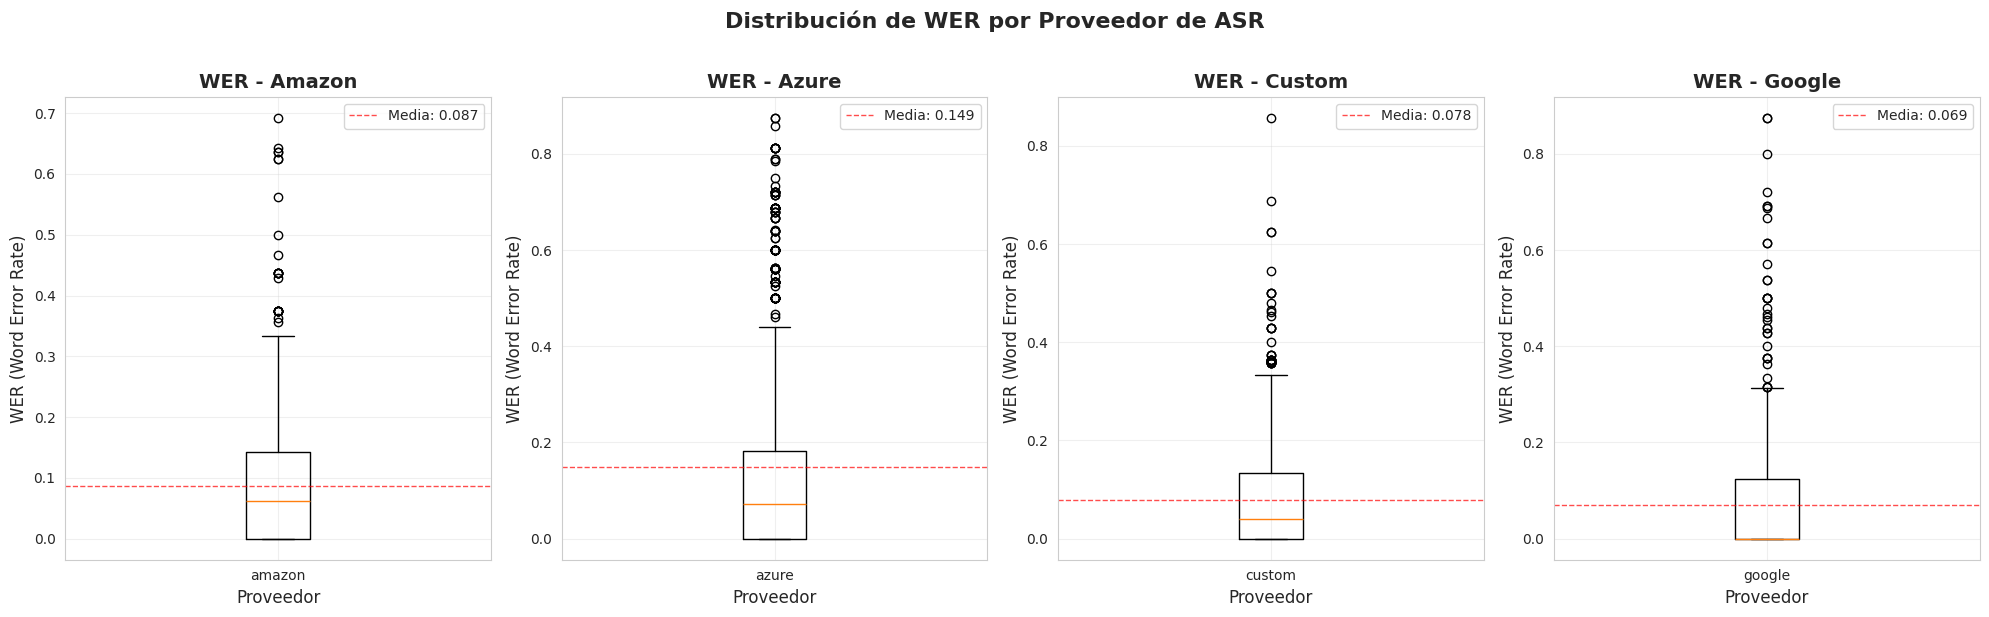


Estadísticas de WER por Proveedor:

AMAZON:
  Media:    0.0870
  Mediana:  0.0625
  Mínimo:   0.0000
  Máximo:   0.6923
  Desv. Est: 0.1053
  Muestras: 1050

AZURE:
  Media:    0.1491
  Mediana:  0.0714
  Mínimo:   0.0000
  Máximo:   0.8750
  Desv. Est: 0.1976
  Muestras: 1050

CUSTOM:
  Media:    0.0782
  Mediana:  0.0400
  Mínimo:   0.0000
  Máximo:   0.8571
  Desv. Est: 0.1072
  Muestras: 1050

GOOGLE:
  Media:    0.0691
  Mediana:  0.0000
  Mínimo:   0.0000
  Máximo:   0.8750
  Desv. Est: 0.1137
  Muestras: 1050


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo de seaborn para gráficos más atractivos
sns.set_style("whitegrid")

# Obtener la lista de proveedores únicos
providers = df_wer['provider'].unique()

# Crear una figura con subplots para cada proveedor
fig, axes = plt.subplots(1, len(providers), figsize=(5*len(providers), 6))

# Crear un boxplot para cada proveedor
for idx, provider in enumerate(sorted(providers)):
    # Filtrar datos por proveedor
    provider_data = df_wer[df_wer['provider'] == provider]['wer']
    
    # Crear el boxplot
    axes[idx].boxplot(provider_data, tick_labels=[provider])
    axes[idx].set_title(f'WER - {provider.capitalize()}', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('WER (Word Error Rate)', fontsize=12)
    axes[idx].set_xlabel('Proveedor', fontsize=12)
    axes[idx].grid(True, alpha=0.3)
    
    # Agregar estadísticas básicas
    mean_wer = provider_data.mean()
    median_wer = provider_data.median()
    axes[idx].axhline(y=mean_wer, color='r', linestyle='--', linewidth=1, alpha=0.7, label=f'Media: {mean_wer:.3f}')
    axes[idx].legend()

plt.suptitle('Distribución de WER por Proveedor de ASR', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Mostrar estadísticas descriptivas por proveedor
print("\nEstadísticas de WER por Proveedor:")
for provider in sorted(providers):
    provider_data = df_wer[df_wer['provider'] == provider]['wer']
    print(f"\n{provider.upper()}:")
    print(f"  Media:    {provider_data.mean():.4f}")
    print(f"  Mediana:  {provider_data.median():.4f}")
    print(f"  Mínimo:   {provider_data.min():.4f}")
    print(f"  Máximo:   {provider_data.max():.4f}")
    print(f"  Desv. Est: {provider_data.std():.4f}")
    print(f"  Muestras: {len(provider_data)}")

In [16]:
display(df_wer.sort_values(by='wer', ascending=False).head(5)[['provider','wer']])

,provider,wer
3784,google,0.875000
3338,azure,0.875000
3787,google,0.875000
3337,azure,0.875000
3984,azure,0.857143


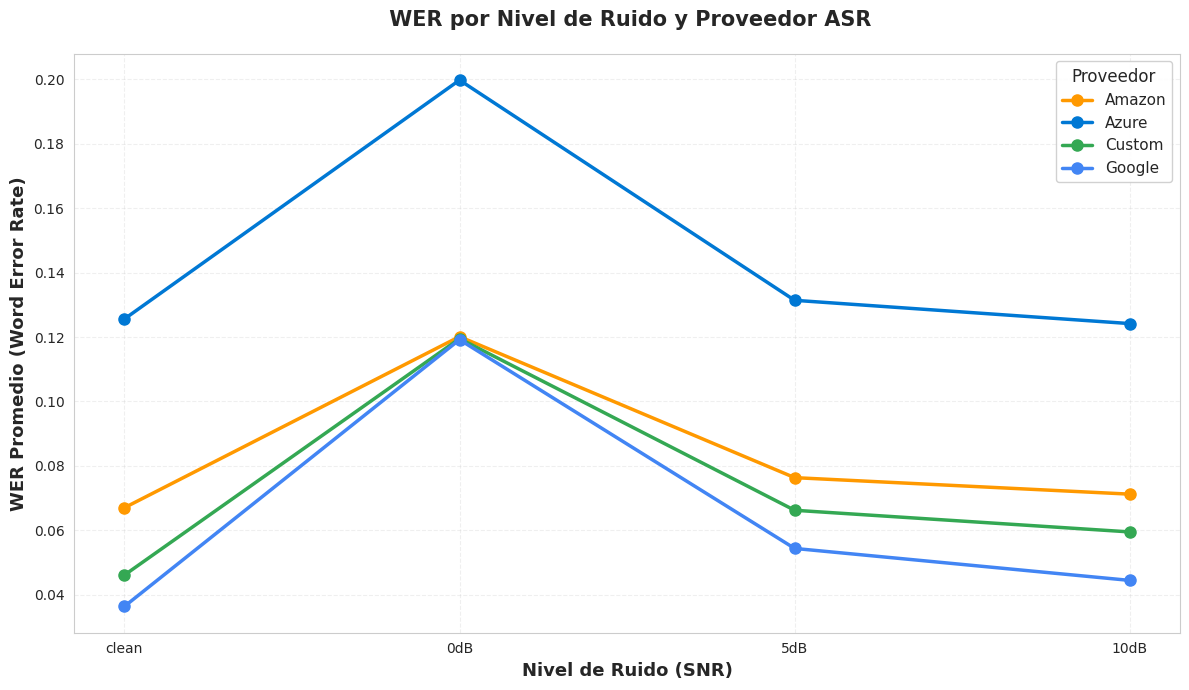


WER Promedio por Proveedor y Nivel de SNR:


provider,amazon,azure,custom,google
snr_normalized,,,,
clean,0.067037,0.125592,0.046146,0.036427
0dB,0.120122,0.199698,0.119512,0.119176
5dB,0.076372,0.131383,0.066250,0.054412
10dB,0.071253,0.124165,0.059533,0.044495




Comparación de Degradación del WER:

AMAZON:
  WER en condiciones limpias (clean): 0.0670
  WER en peor condición (0dB): 0.1201
  Degradación: 79.19%

AZURE:
  WER en condiciones limpias (clean): 0.1256
  WER en peor condición (0dB): 0.1997
  Degradación: 59.01%

CUSTOM:
  WER en condiciones limpias (clean): 0.0461
  WER en peor condición (0dB): 0.1195
  Degradación: 158.98%

GOOGLE:
  WER en condiciones limpias (clean): 0.0364
  WER en peor condición (0dB): 0.1192
  Degradación: 227.16%


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Configurar estilo
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# Definir el orden correcto de los niveles de SNR
snr_order = ['clean', '0dB', '5dB', '10dB']

# Preparar los datos: calcular WER promedio por provider y SNR
# Normalizar los valores de SNR para asegurar consistencia
df_wer['snr_normalized'] = df_wer['snr'].astype(str).str.lower().str.replace('db', 'dB')

# Reemplazar 'nan' por 'clean' si es necesario
df_wer.loc[df_wer['snr_normalized'] == 'nan', 'snr_normalized'] = 'clean'

# Agrupar por provider y snr_normalized, calculando el WER promedio
wer_by_provider_snr = df_wer.groupby(['provider', 'snr_normalized'])['wer'].mean().reset_index()

# Obtener lista de proveedores únicos
providers = sorted(df_wer['provider'].unique())

# Definir colores para cada proveedor
colors = {
    'google': '#4285F4',   # Azul Google
    'azure': '#0078D4',    # Azul Azure
    'amazon': '#FF9900',   # Naranja Amazon
    'custom': '#34A853'    # Verde
}

# Crear el gráfico de líneas
for provider in providers:
    # Filtrar datos para este proveedor
    provider_data = wer_by_provider_snr[wer_by_provider_snr['provider'] == provider]
    
    # Crear un DataFrame con todos los niveles de SNR para asegurar continuidad
    provider_full = pd.DataFrame({'snr_normalized': snr_order})
    provider_full = provider_full.merge(provider_data, on='snr_normalized', how='left')
    
    # Graficar la línea
    plt.plot(provider_full['snr_normalized'], 
             provider_full['wer'], 
             marker='o', 
             linewidth=2.5, 
             markersize=8,
             label=provider.capitalize(),
             color=colors.get(provider, None),
             linestyle='-')

# Configurar el gráfico
plt.xlabel('Nivel de Ruido (SNR)', fontsize=13, fontweight='bold')
plt.ylabel('WER Promedio (Word Error Rate)', fontsize=13, fontweight='bold')
plt.title(' WER por Nivel de Ruido y Proveedor ASR', 
          fontsize=15, fontweight='bold', pad=20)

# Configurar leyenda
plt.legend(title='Proveedor', fontsize=11, title_fontsize=12, 
           loc='best', framealpha=0.9)

# Configurar grid
plt.grid(True, alpha=0.3, linestyle='--')

# Ajustar layout
plt.tight_layout()
plt.show()

# Mostrar tabla de datos resumen
print("\nWER Promedio por Proveedor y Nivel de SNR:")
print("="*70)
pivot_table = wer_by_provider_snr.pivot(index='snr_normalized', 
                                         columns='provider', 
                                         values='wer')
# Reordenar las filas según snr_order
pivot_table = pivot_table.reindex([snr for snr in snr_order if snr in pivot_table.index])
display(pivot_table)

# Mostrar estadísticas adicionales
print("\n\nComparación de Degradación del WER:")
for provider in providers:
    provider_data = wer_by_provider_snr[wer_by_provider_snr['provider'] == provider]
    provider_data = provider_data.set_index('snr_normalized').reindex(snr_order)
    
    if 'clean' in provider_data.index and not pd.isna(provider_data.loc['clean', 'wer']):
        clean_wer = provider_data.loc['clean', 'wer']
        print(f"\n{provider.upper()}:")
        print(f"  WER en condiciones limpias (clean): {clean_wer:.4f}")
        
        if '0dB' in provider_data.index and not pd.isna(provider_data.loc['0dB', 'wer']):
            worst_wer = provider_data.loc['0dB', 'wer']
            degradation = ((worst_wer - clean_wer) / clean_wer) * 100
            print(f"  WER en peor condición (0dB): {worst_wer:.4f}")
            print(f"  Degradación: {degradation:.2f}%")